In [1]:
# data stuff:
import pandas as pd
import numpy as np
import optuna
from tqdm import tqdm

from sklearn.model_selection import TimeSeriesSplit

# plotting stuff:
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

# stats stuff:
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.regression.linear_model import yule_walker

# silence!
import warnings
warnings.filterwarnings("ignore")

---
## The SARIMA Model:

The SARIMA models adds a "seasonality" effect to the univariate models seem previously, namely, the ARIMA model.

See page 116 of "Advanced Forecasting with Python".

---

### Load data and aggregate weekly sales across all stores:

In [6]:
data = pd.read_csv('data/walmart_train.csv', usecols=['Date', 'Weekly_Sales'])
data = data.groupby('Date')[['Weekly_Sales']].sum()
data

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


### Plot weekly sales:

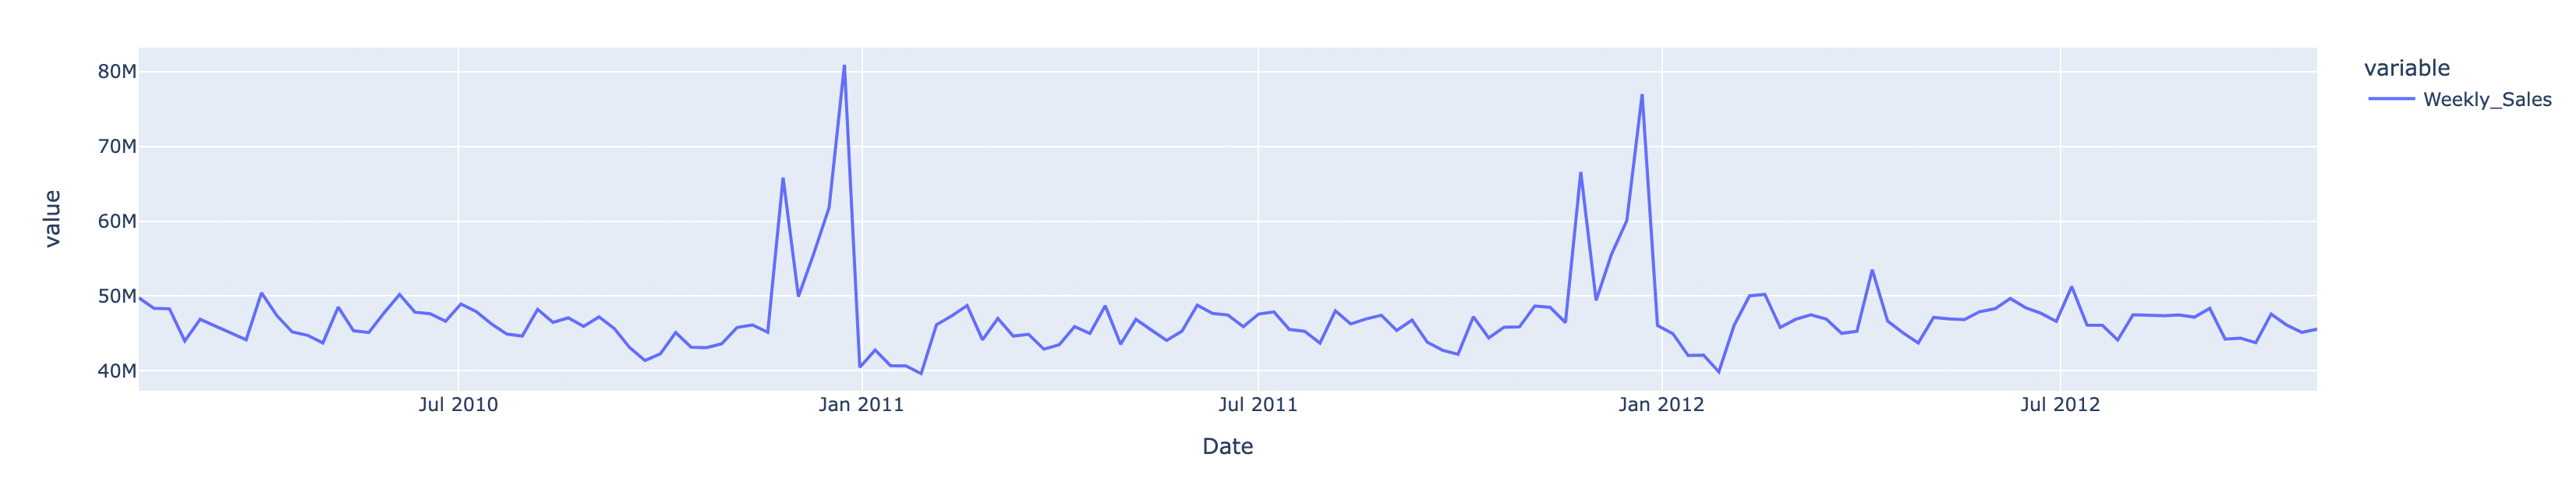

In [19]:
px.line(data)
Image(filename='./images/ch7_origseries.png', width=1600)

Already we can see the seasonality influence around December of each year (holidays).

&nbsp;

### Fit a SARIMA(1,1,1)(1,1,1)52 model:
We choose (1, 1, 1) for the order of AR, I, and MA. Also (1, 1, 1) for their seasonal params. Last, 52 cause we're dealing with weekly data.

In [10]:
# split:
train = data['Weekly_Sales'][:-10]
test = data['Weekly_Sales'][-10:]

# initialize and fit:
mod = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,52))
res = mod.fit(disp=False)

# forecast 10 steps (weeks):
fcst = res.forecast(steps=10)

### Obtain R-squared score:

In [12]:
print(r2_score(test, fcst))

0.7309576478599619


### Plot forecast against the test set:

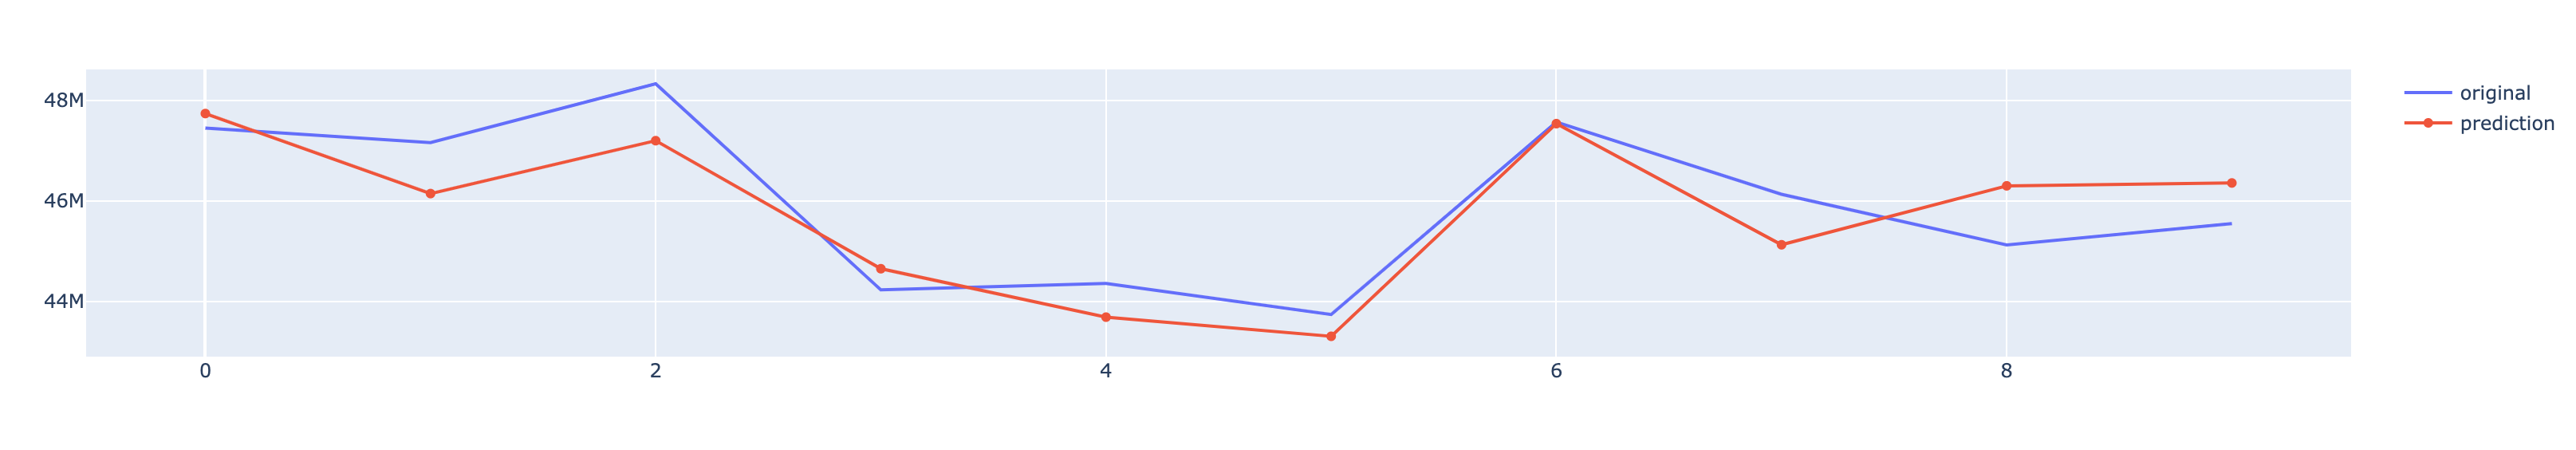

In [20]:
fig = go.Figure()
# original
fig.add_trace(go.Scatter(y=test, mode='lines', name='original'))

# predicted:
fig.add_trace(go.Scatter(y=fcst, mode='lines+markers', name='prediction'))
Image(filename='./images/ch7_firstfit.png', width=1600)

&nbsp;

### Find best parameters for SARIMA using Optuna:

In [14]:
def objective_sarima(trial):
    # define search space for each model's order:
    p=trial.suggest_int('p', 1, 3, step=1)
    i=trial.suggest_int('i', 1, 3, step=1)
    q=trial.suggest_int('q', 1, 3, step=1)
    
    # seasonal orders:
    P=trial.suggest_int('P', 1, 3, step=1)
    D=trial.suggest_int('D', 1, 3, step=1)
    Q=trial.suggest_int('Q', 1, 3, step=1)
    seasonal_order=52

    # initialize model and fit:
    try:
        model=sm.tsa.statespace.SARIMAX(train, order=(p,i,q), seasonal_order=(P,D,Q,seasonal_order))
        mdl = model.fit(disp=False)

        # predict on the fold:
        preds = mdl.forecast(steps=10)

        # obtain residuals and evaluate using r-squared:
        score = r2_score(test, preds)
        
        # delete fitted models after eval:
        del model
        del mdl
        
    except:
        print('errored')

    return score

In [16]:
# find optimal params (orders) that will maximize R-squared value:
study=optuna.create_study(direction="maximize")
study.optimize(objective_sarima, n_trials=25)

[I 2022-06-07 17:56:55,317] A new study created in memory with name: no-name-9d314047-bb58-4355-a4f8-362bfc43b0d7
[I 2022-06-07 18:02:30,779] Trial 0 finished with value: -7.474734996147122 and parameters: {'p': 3, 'i': 3, 'q': 2, 'P': 3, 'D': 1, 'Q': 2}. Best is trial 0 with value: -7.474734996147122.
[I 2022-06-07 18:10:19,677] Trial 1 finished with value: 0.6632913039286654 and parameters: {'p': 2, 'i': 1, 'q': 1, 'P': 3, 'D': 2, 'Q': 1}. Best is trial 1 with value: 0.6632913039286654.
[I 2022-06-07 18:22:15,071] Trial 2 finished with value: -1.97002068859726 and parameters: {'p': 2, 'i': 3, 'q': 3, 'P': 3, 'D': 2, 'Q': 2}. Best is trial 1 with value: 0.6632913039286654.
[I 2022-06-07 18:25:33,190] Trial 3 finished with value: 0.6036169948266021 and parameters: {'p': 2, 'i': 2, 'q': 3, 'P': 2, 'D': 1, 'Q': 1}. Best is trial 1 with value: 0.6632913039286654.
[I 2022-06-07 18:26:04,809] Trial 4 finished with value: -5.183664789547603 and parameters: {'p': 3, 'i': 2, 'q': 3, 'P': 2, 'D

### Obtain best parameters from the optimization study:

In [17]:
# optimal result and corresponding params:
trial=study.best_trial

# top r-squared value:
trial_value = np.round(trial.value, 2)

print(f"R-squared: {trial_value}")
print("best params for SARIMA: {}".format(trial.params))

R-squared: 0.74
best params for SARIMA: {'p': 1, 'i': 1, 'q': 2, 'P': 3, 'D': 1, 'Q': 3}


&nbsp;

### Explore results with best params:

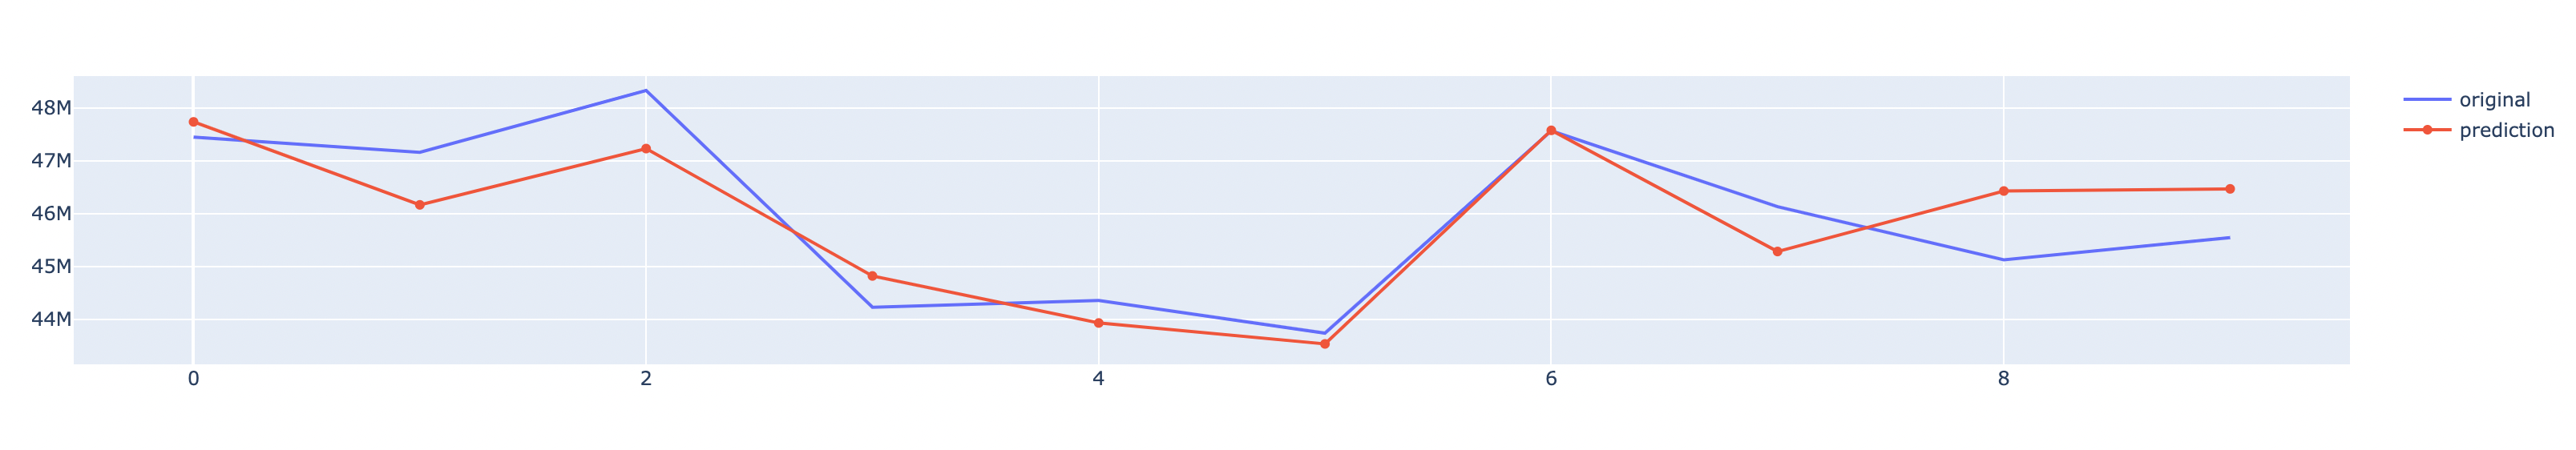

In [21]:
# fit:
model=sm.tsa.statespace.SARIMAX(train, order=(1,1,2), seasonal_order=(3,1,3,52))
mdl = model.fit(disp=False)

# predict and evaluate:
preds = mdl.forecast(steps=10)
score = r2_score(test, preds)

# plot:
fig = go.Figure()
# original
fig.add_trace(go.Scatter(y=test, mode='lines', name='original'))

# predicted:
fig.add_trace(go.Scatter(y=preds, mode='lines+markers', name='prediction'))
Image(filename='./images/ch7_finalfit.png', width=1600)